In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
train_data = pd.read_csv('Training set values.csv')
test_data = pd.read_csv('Test set values.csv')
labels = pd.read_csv('Training set labels.csv')
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# 1. Información del dataset y primer análisis exploratorio

In [4]:
train_data.shape

(59400, 40)

In [5]:
labels.shape

(59400, 2)

In [6]:
test_data.shape

(14850, 40)

In [7]:
train_data

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [8]:
labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [9]:
train_data_total = train_data.merge(labels, on='id')

In [10]:
# Fusionar los conjuntos de entrenamiento y prueba
ntrain = train_data_total.shape[0]
ntest = test_data.shape[0]
data_total = pd.concat((train_data_total, test_data)).reset_index(drop=True)

In [11]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

In [12]:
for columna in data_total.columns:
    print(f'Columna: {columna}')
    print(data_total[columna].dropna().unique()[:10])  # Muestra de los primeros 10 valores únicos
    print('-' * 40)

Columna: id
[69572  8776 34310 67743 19728  9944 19816 54551 53934 46144]
----------------------------------------
Columna: amount_tsh
[6000.    0.   25.   20.  200.  500.   50. 4000. 1500.    6.]
----------------------------------------
Columna: date_recorded
['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03']
----------------------------------------
Columna: funder
['Roman' 'Grumeti' 'Lottery Club' 'Unicef' 'Action In A'
 'Mkinga Distric Coun' 'Dwsp' 'Rwssp' 'Wateraid' 'Isingiro Ho']
----------------------------------------
Columna: gps_height
[1390 1399  686  263    0   62 1062 1368 1645 1703]
----------------------------------------
Columna: installer
['Roman' 'GRUMETI' 'World vision' 'UNICEF' 'Artisan' 'DWE' 'DWSP'
 'Water Aid' 'Private' 'DANIDA']
----------------------------------------
Columna: longitude
[34.93809275 34.6987661  37.46066446 38.48616088 31.13084671 39.1727956
 33.36240982 32.62061707

#### Lista de transformaciones iniciales:

1. Status_Group debe ser convertida a numérica (Además es la variable objetivo)

2. En el procesado de datos se debe convertir todas las variables categóricas a numéricas

3. Algunas variables se pueden convertir a binario: permit y public_meeting

4. Date recorded se debe convertir a un formato válido

5. Hay grupos de variables que son redundantes como water_quality y quality_group

In [18]:
print(data_total.describe(include='all'))

                  id     amount_tsh date_recorded                  funder  \
count   74250.000000   74250.000000         74250                   74250   
unique           NaN            NaN           369                    2140   
top              NaN            NaN    2011-03-17  Government Of Tanzania   
freq             NaN            NaN           695                   11299   
mean    37124.500000     318.685704           NaN                     NaN   
std     21434.273081    2906.762364           NaN                     NaN   
min         0.000000       0.000000           NaN                     NaN   
25%     18562.250000       0.000000           NaN                     NaN   
50%     37124.500000       0.000000           NaN                     NaN   
75%     55686.750000      20.000000           NaN                     NaN   
max     74249.000000  350000.000000           NaN                     NaN   

          gps_height installer     longitude      latitude wpt_name  \
coun

In [14]:
lista_categoricas = data_total.select_dtypes(include=['object']).columns
for feature in lista_categoricas:
    print(f"\n{feature} distribution:")
    print(data_total[feature].value_counts())


date_recorded distribution:
date_recorded
2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
             ... 
2011-09-01      1
2011-09-28      1
2011-09-16      1
2011-09-13      1
2004-01-09      1
Name: count, Length: 369, dtype: int64

funder distribution:
funder
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
                          ...  
Sido                          1
Mosqure                       1
Kkkt Canal                    1
Rc Missionary                 1
Velem                         1
Name: count, Length: 2139, dtype: int64

installer distribution:
installer
DWE                       21751
Government                 2282
RWE                        1498
Commu                      1347
DANIDA                     1305
                          ...  
MANDIA CONSTRUCTION           1
Megis                         1
ISSAA KA

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


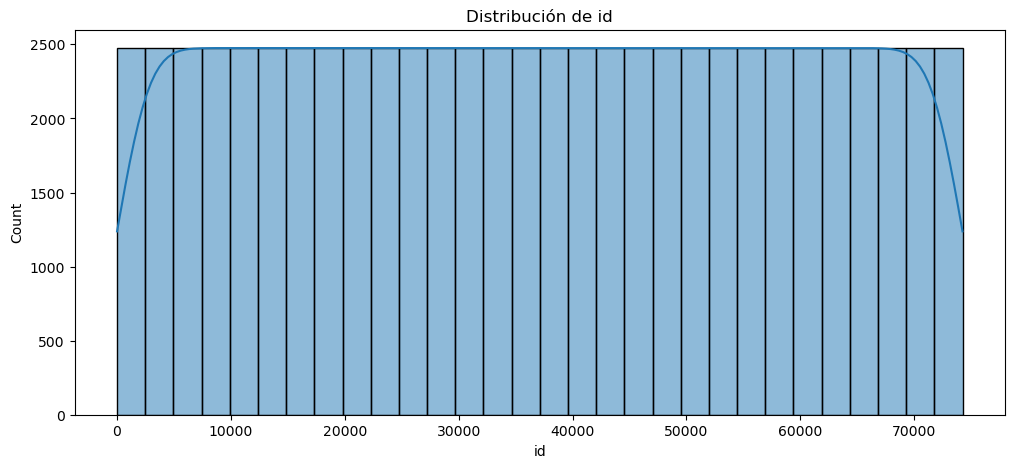

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


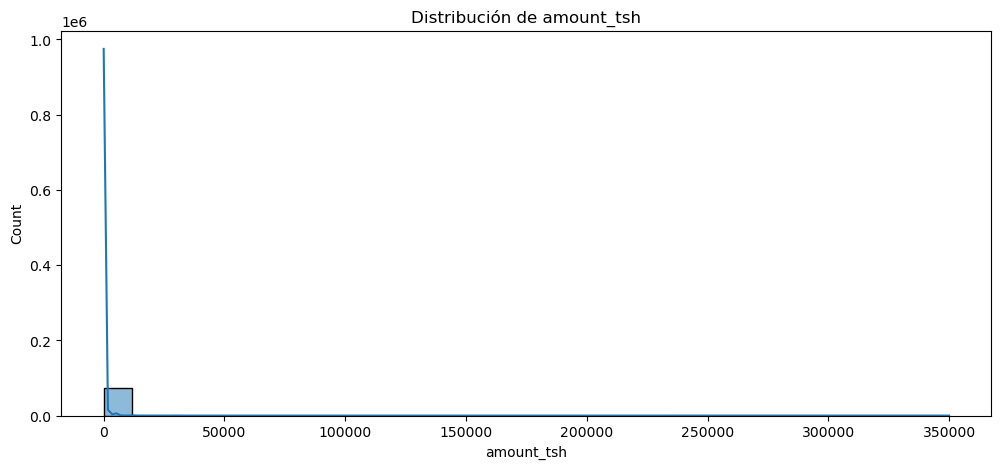

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


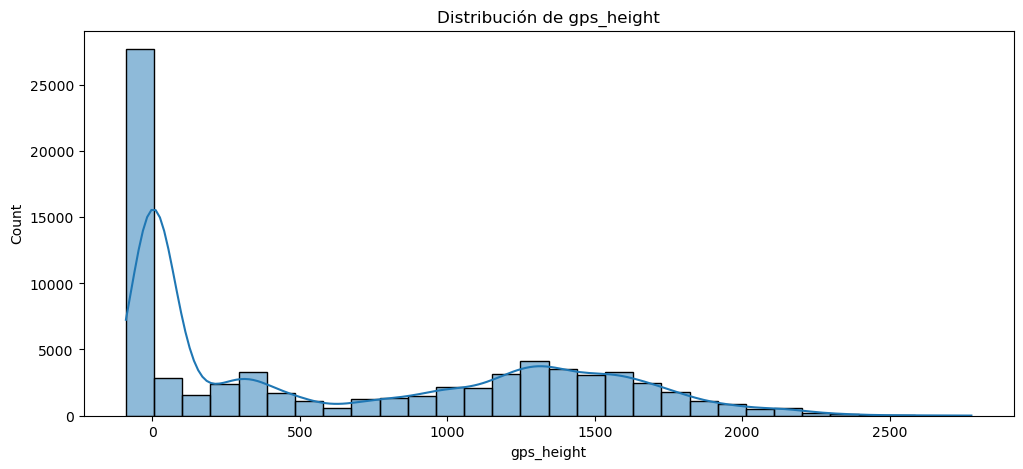

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


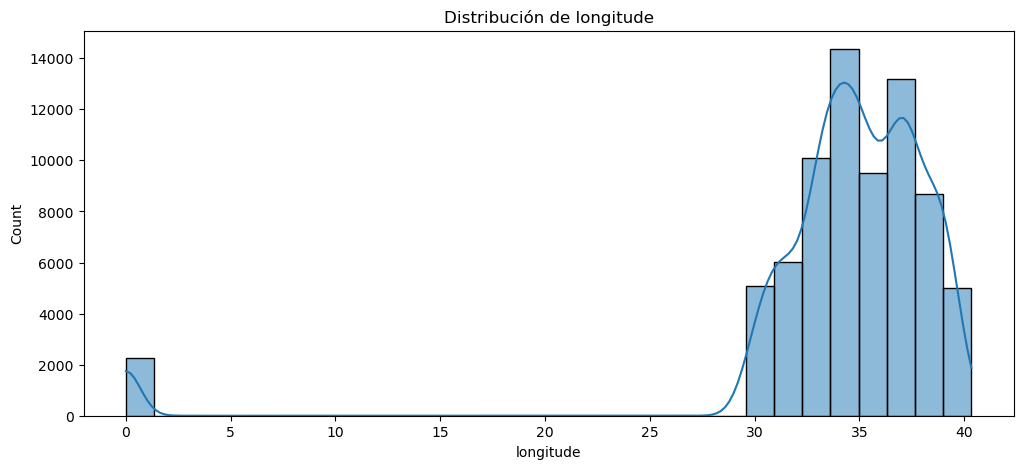

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


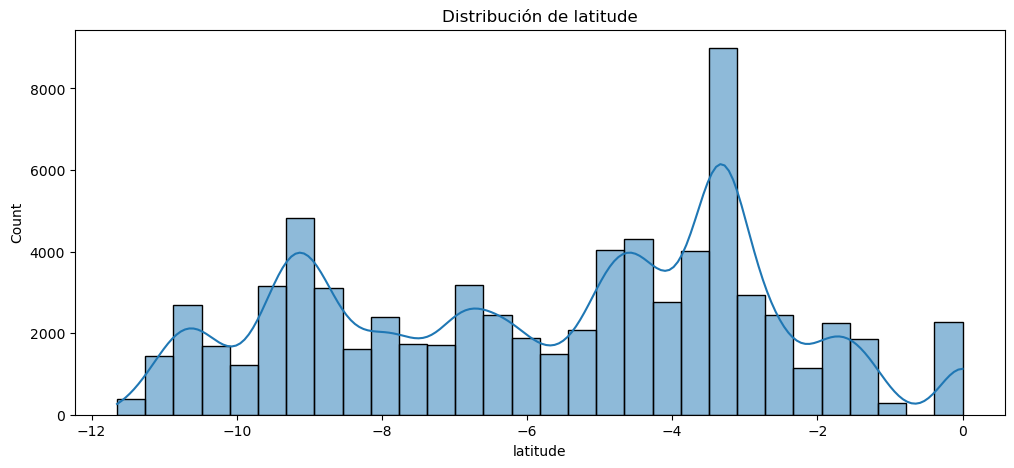

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


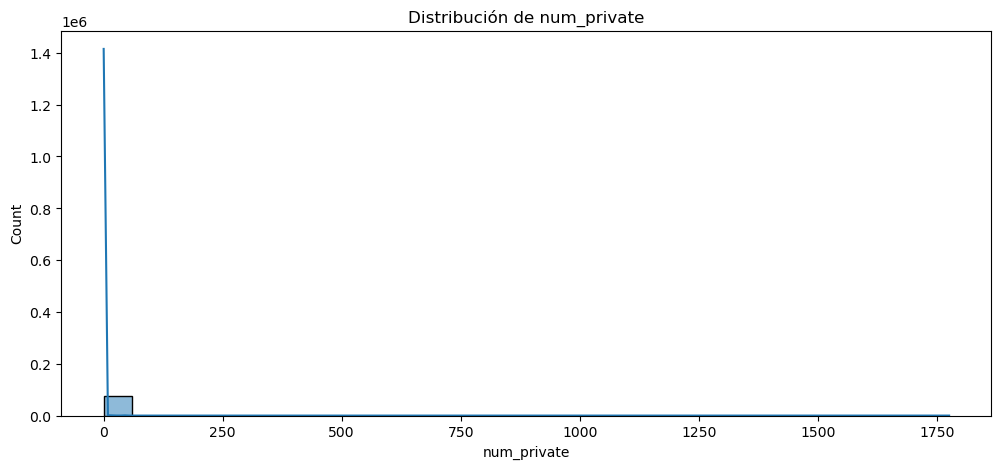

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


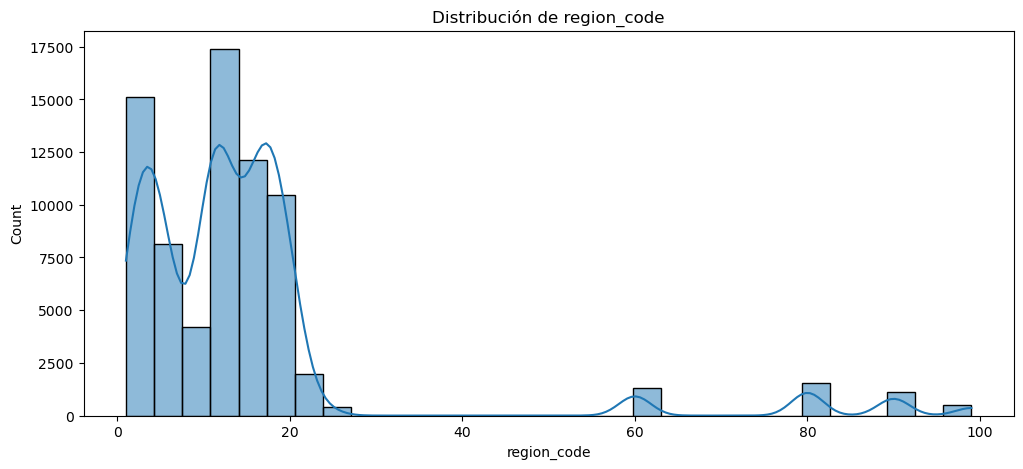

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


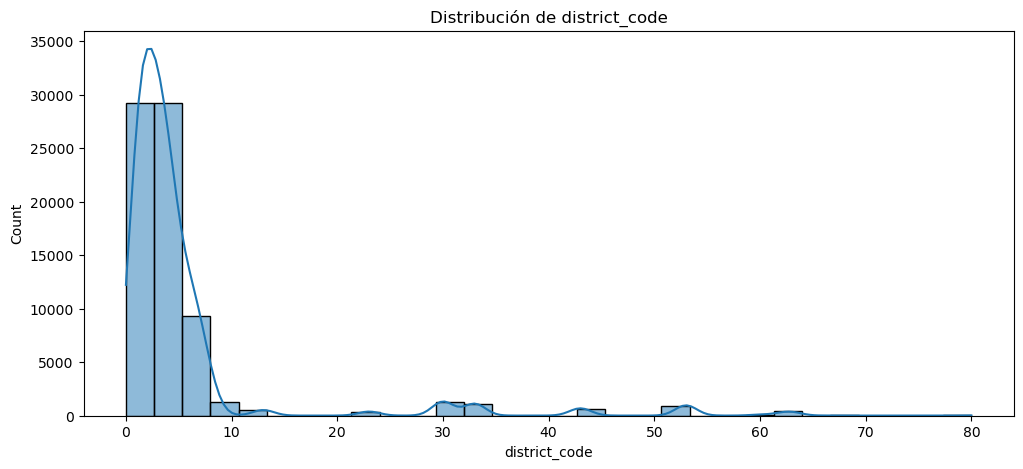

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


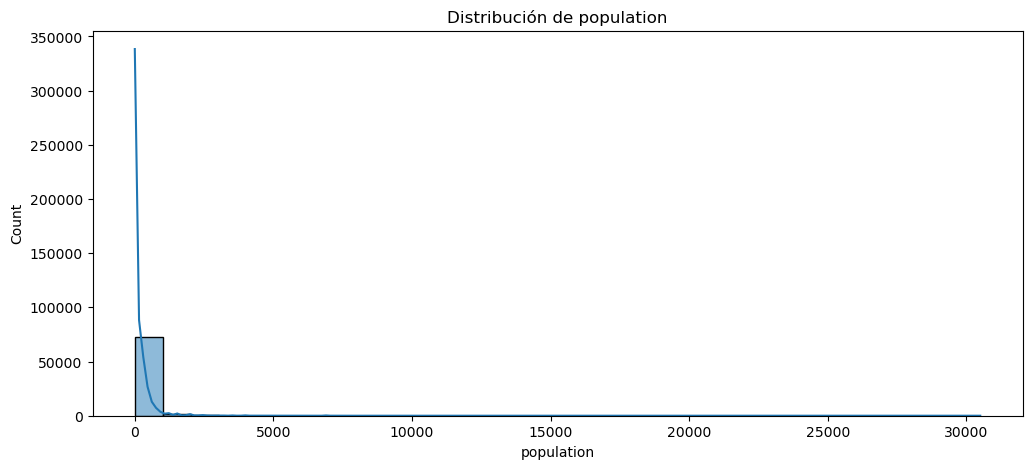

C:\Users\adria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


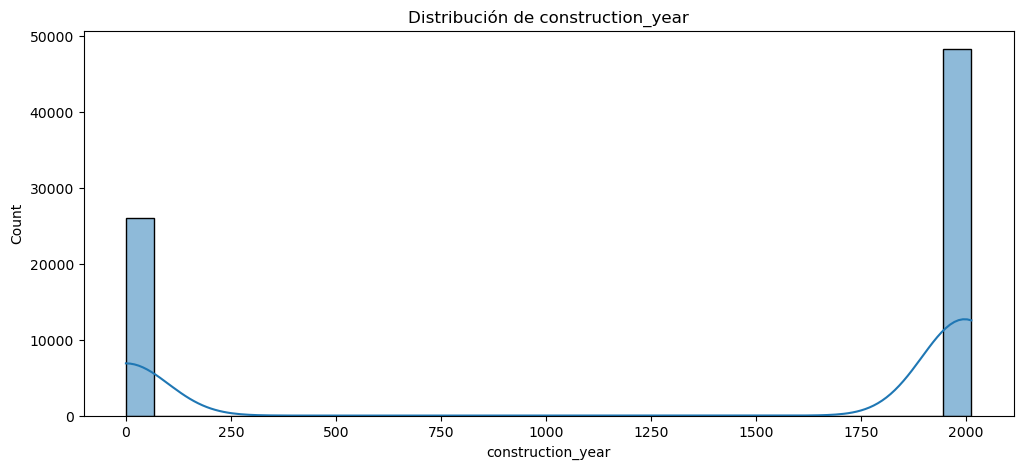

In [13]:
lista_numéricas = data_total.select_dtypes(include=[np.number]).columns
for feature in lista_numéricas:
    plt.figure(figsize=(12, 5))
    sns.histplot(data_total[feature], kde=True, bins=30)
    plt.title(f'Distribución de {feature}')
    plt.show()

In [40]:
data_total.shape

(74250, 40)

## Valores duplicados


In [41]:
data_total.duplicated().sum()

0

In [ ]:
## Valores perdidos

In [42]:
data_total.isnull().sum().sort_values(ascending=False)

id                       0
amount_tsh               0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
scheme_name              0
scheme_management        0
recorded_by              0
num_private              0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
basin                    0
public_meeting           0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
w

# 2. Preprocesado de los datos

In [15]:
status_mapping = {
    'functional': 1,
    'functional needs repair': 2,
    'non functional': 0
}

In [16]:
data_total['status_group_numeric'] = data_total['status_group'].map(status_mapping)
# Dropear la columna original status_group
data_total = data_total.drop('status_group', axis=1)

In [17]:
data_total

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group_numeric
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1.0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0.0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,NaN
74246,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,NaN
74247,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,NaN
74248,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,NaN


In [18]:
data_total.isnull().sum().sort_values(ascending=False)

scheme_name              36052
status_group_numeric     14850
scheme_management         4847
installer                 4532
funder                    4507
public_meeting            4155
permit                    3793
subvillage                 470
wpt_name                     2
quality_group                0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
latitude                     0
extraction_type_group        0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
quantity                     0
extraction_type              0
construction_year            0
gps_height                   0
date_recorded                0
amount_tsh                   0
recorded_by                  0
longitude                    0
populati

In [17]:
missed = ["scheme_management", "installer", "funder", "public_meeting", "permit", "subvillage", 'status_group_numeric']
for m in missed:
    data_total[m] = data_total[m].fillna("UNKNOWN")

KeyError: 'status_group_numeric'

In [20]:
data_total.isnull().sum().sort_values(ascending=False)

scheme_name              36052
wpt_name                     2
id                           0
payment_type                 0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
quality_group                0
water_quality                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
permit                       0
scheme_management            0
amount_tsh                   0
basin                        0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
num_private                  0
subvillage                   0
recorded

In [21]:

# Identificar las características numéricas
numeric_feats = data_total.dtypes[data_total.dtypes != 'object'].index

# Calcular la asimetría de las características numéricas
skewed_feats = data_total[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# Filtrar aquellas características con alta asimetría (mayor que 0.5 o menor que -0.5)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]

# Mostrar las características con alta asimetría
high_skew


num_private          91.325138
amount_tsh           56.368883
population           11.780377
district_code         3.961353
region_code           3.179390
construction_year    -0.629771
longitude            -4.187278
dtype: float64

In [22]:
for feature in high_skew.index:
    data_total[feature] = np.log1p(np.abs(data_total[feature]))

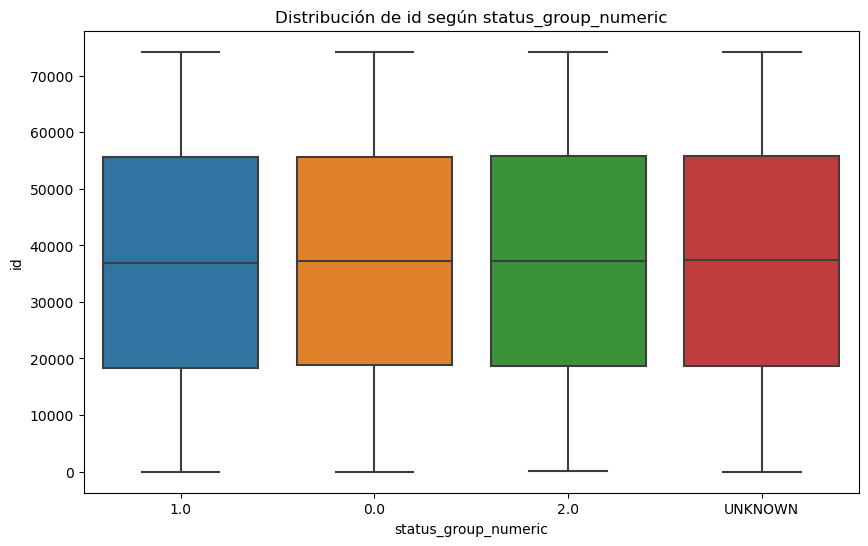

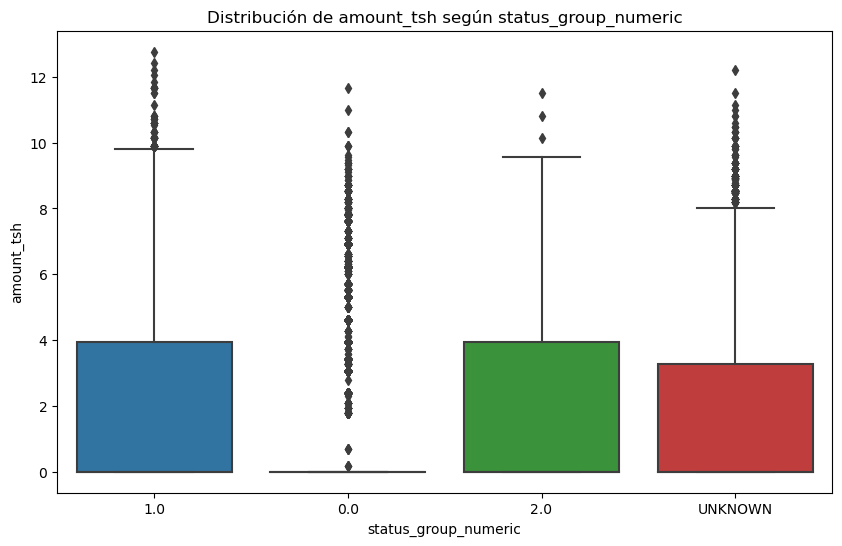

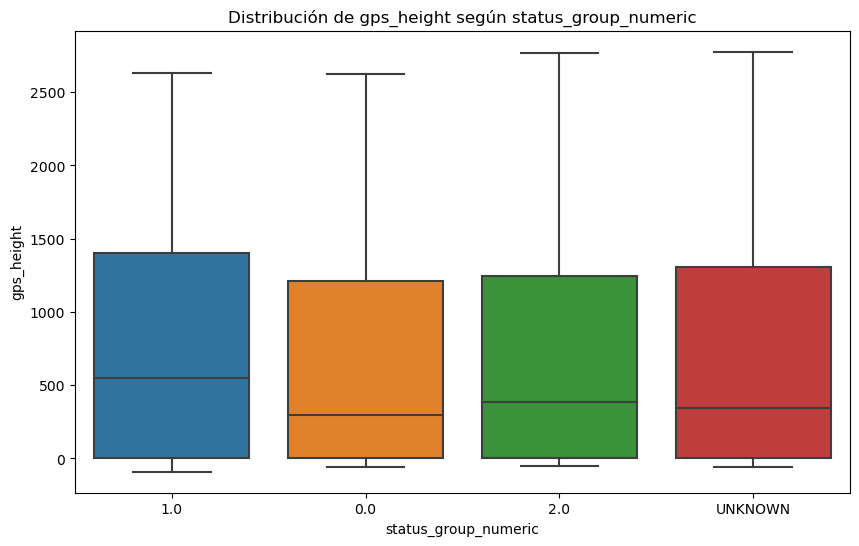

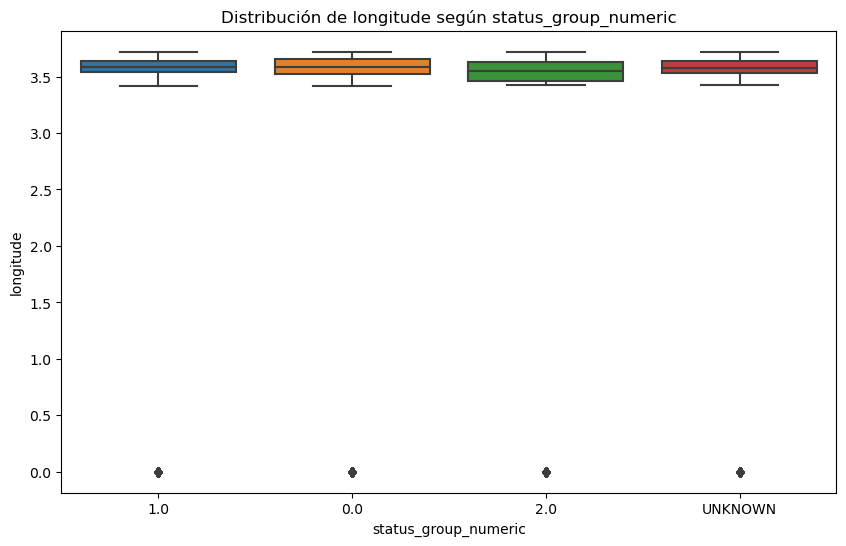

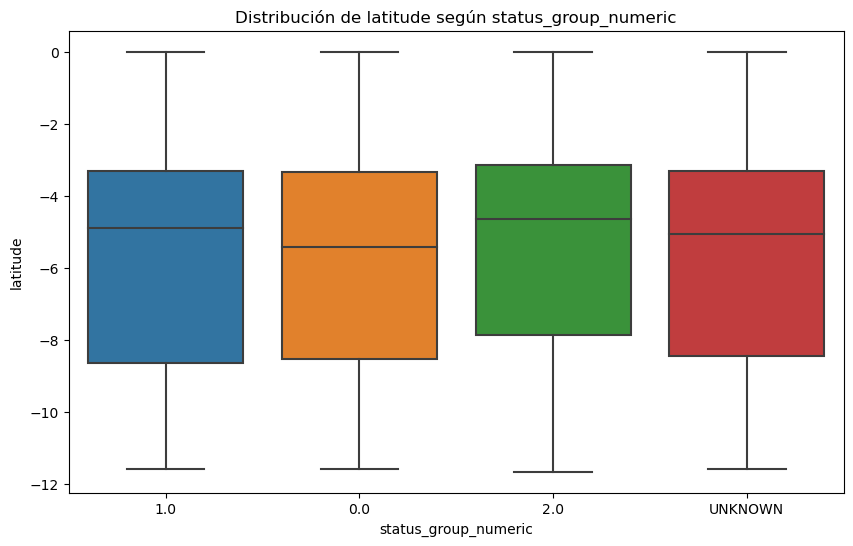

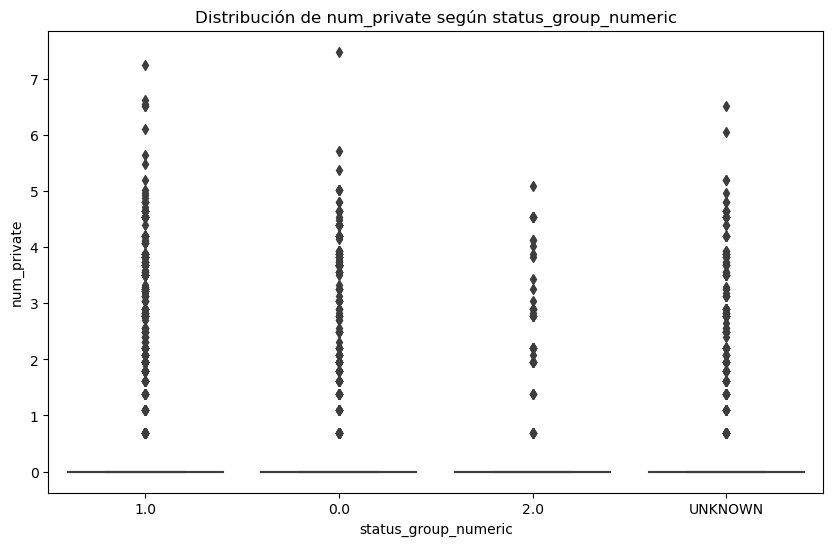

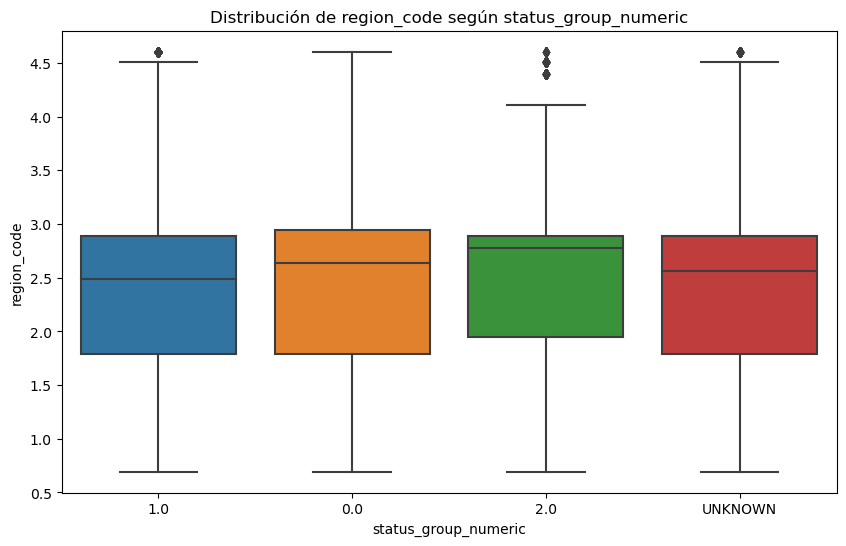

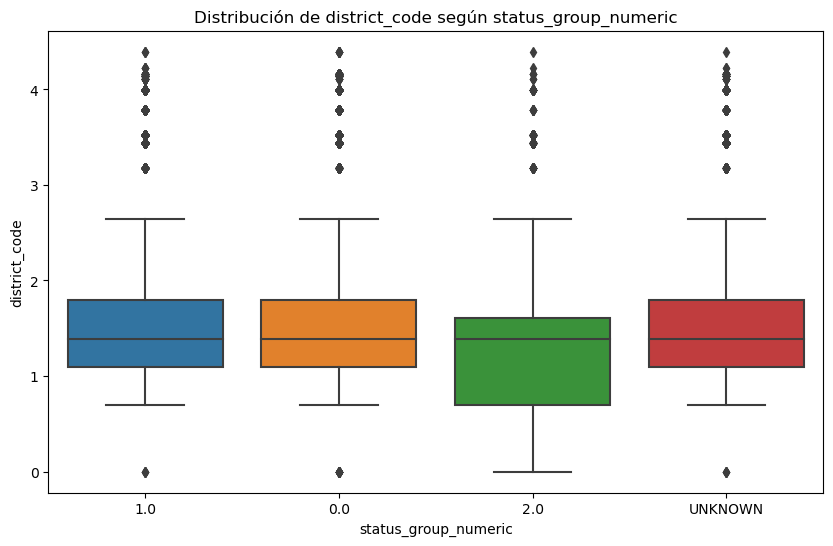

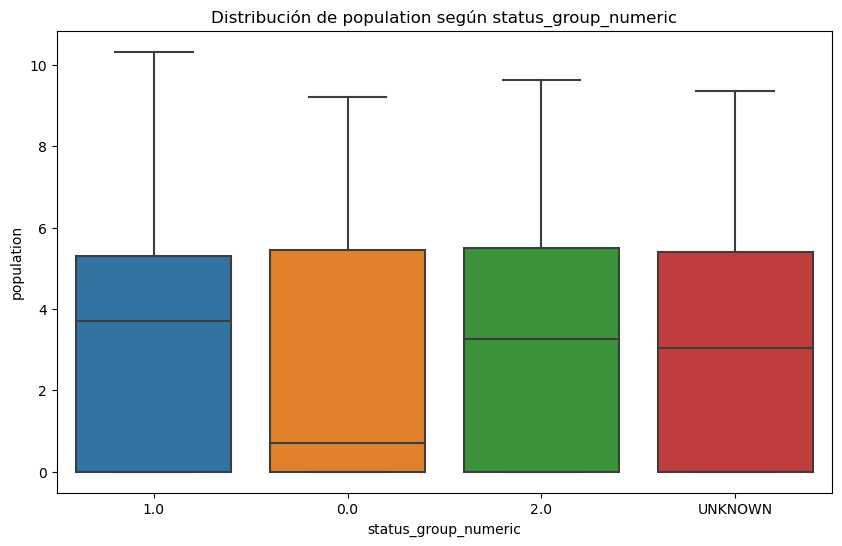

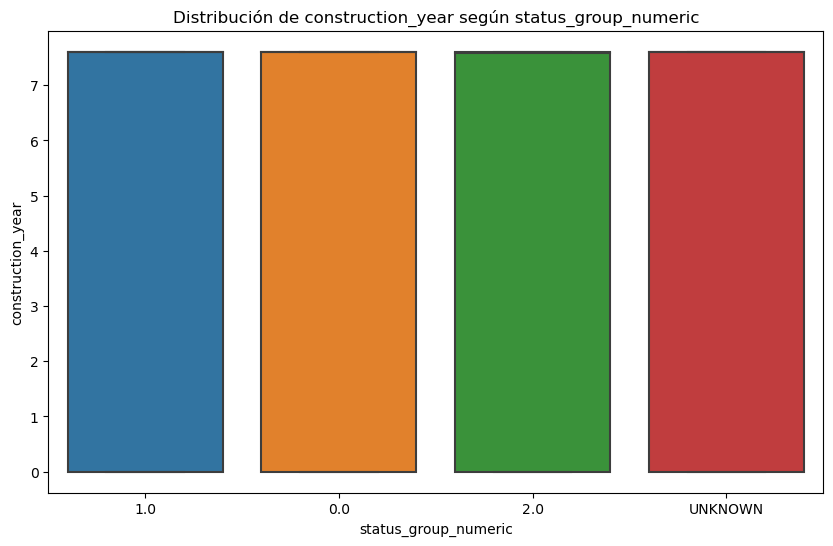

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de que 'status_group_numeric' y otras columnas están en el DataFrame
if 'status_group_numeric' in data_total.columns:
    numeric_features = [feature for feature in data_total.columns if data_total[feature].dtype in ['int64', 'float64']]
    
    for feature in numeric_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data_total, x='status_group_numeric', y=feature)
        plt.title(f'Distribución de {feature} según status_group_numeric')
        plt.show()
else:
    print("'status_group_numeric' no está en el DataFrame")


In [24]:
y_train = data_total.status_group_numeric # Extraer la columna objetivo y las características del conjunto de entrenamiento
data_total = data_total.drop(['status_group_numeric'], axis=1)

In [25]:
y_train

0            1.0
1            1.0
2            1.0
3            0.0
4            1.0
          ...   
74245    UNKNOWN
74246    UNKNOWN
74247    UNKNOWN
74248    UNKNOWN
74249    UNKNOWN
Name: status_group_numeric, Length: 74250, dtype: object

In [26]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 74250 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              74250 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  float64
 10  basin                  74250 non-null  object 
 11  subvillage             74250 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  float64
 14  district_code          74250 non-null  float64
 15  lg

In [27]:
data_total.dtypes[data_total.dtypes == 'object'].index

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [28]:
categoricas = data_total.dtypes[data_total.dtypes == 'object'].index
for cat in categoricas:
    data_total[cat] = data_total[cat].astype('category').cat.codes

In [29]:
data_total.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,8.699681,54,1547,1390,1706,3.581798,-9.856322,45682,0.0,...,0,6,2,1,1,8,6,0,1,1
1,8776,0.000000,322,522,1399,610,3.575116,-2.147466,45425,0.0,...,2,6,2,2,2,5,3,1,1,1
2,34310,3.258097,313,924,686,2297,3.649636,-3.821329,17767,0.0,...,5,6,2,1,1,0,1,1,2,1
3,67743,0.000000,285,1961,263,2078,3.675950,-11.155298,45536,0.0,...,2,6,2,0,0,3,0,0,2,1
4,19728,0.000000,111,20,0,133,3.469817,-1.825359,43410,0.0,...,2,6,2,3,3,5,3,1,1,1


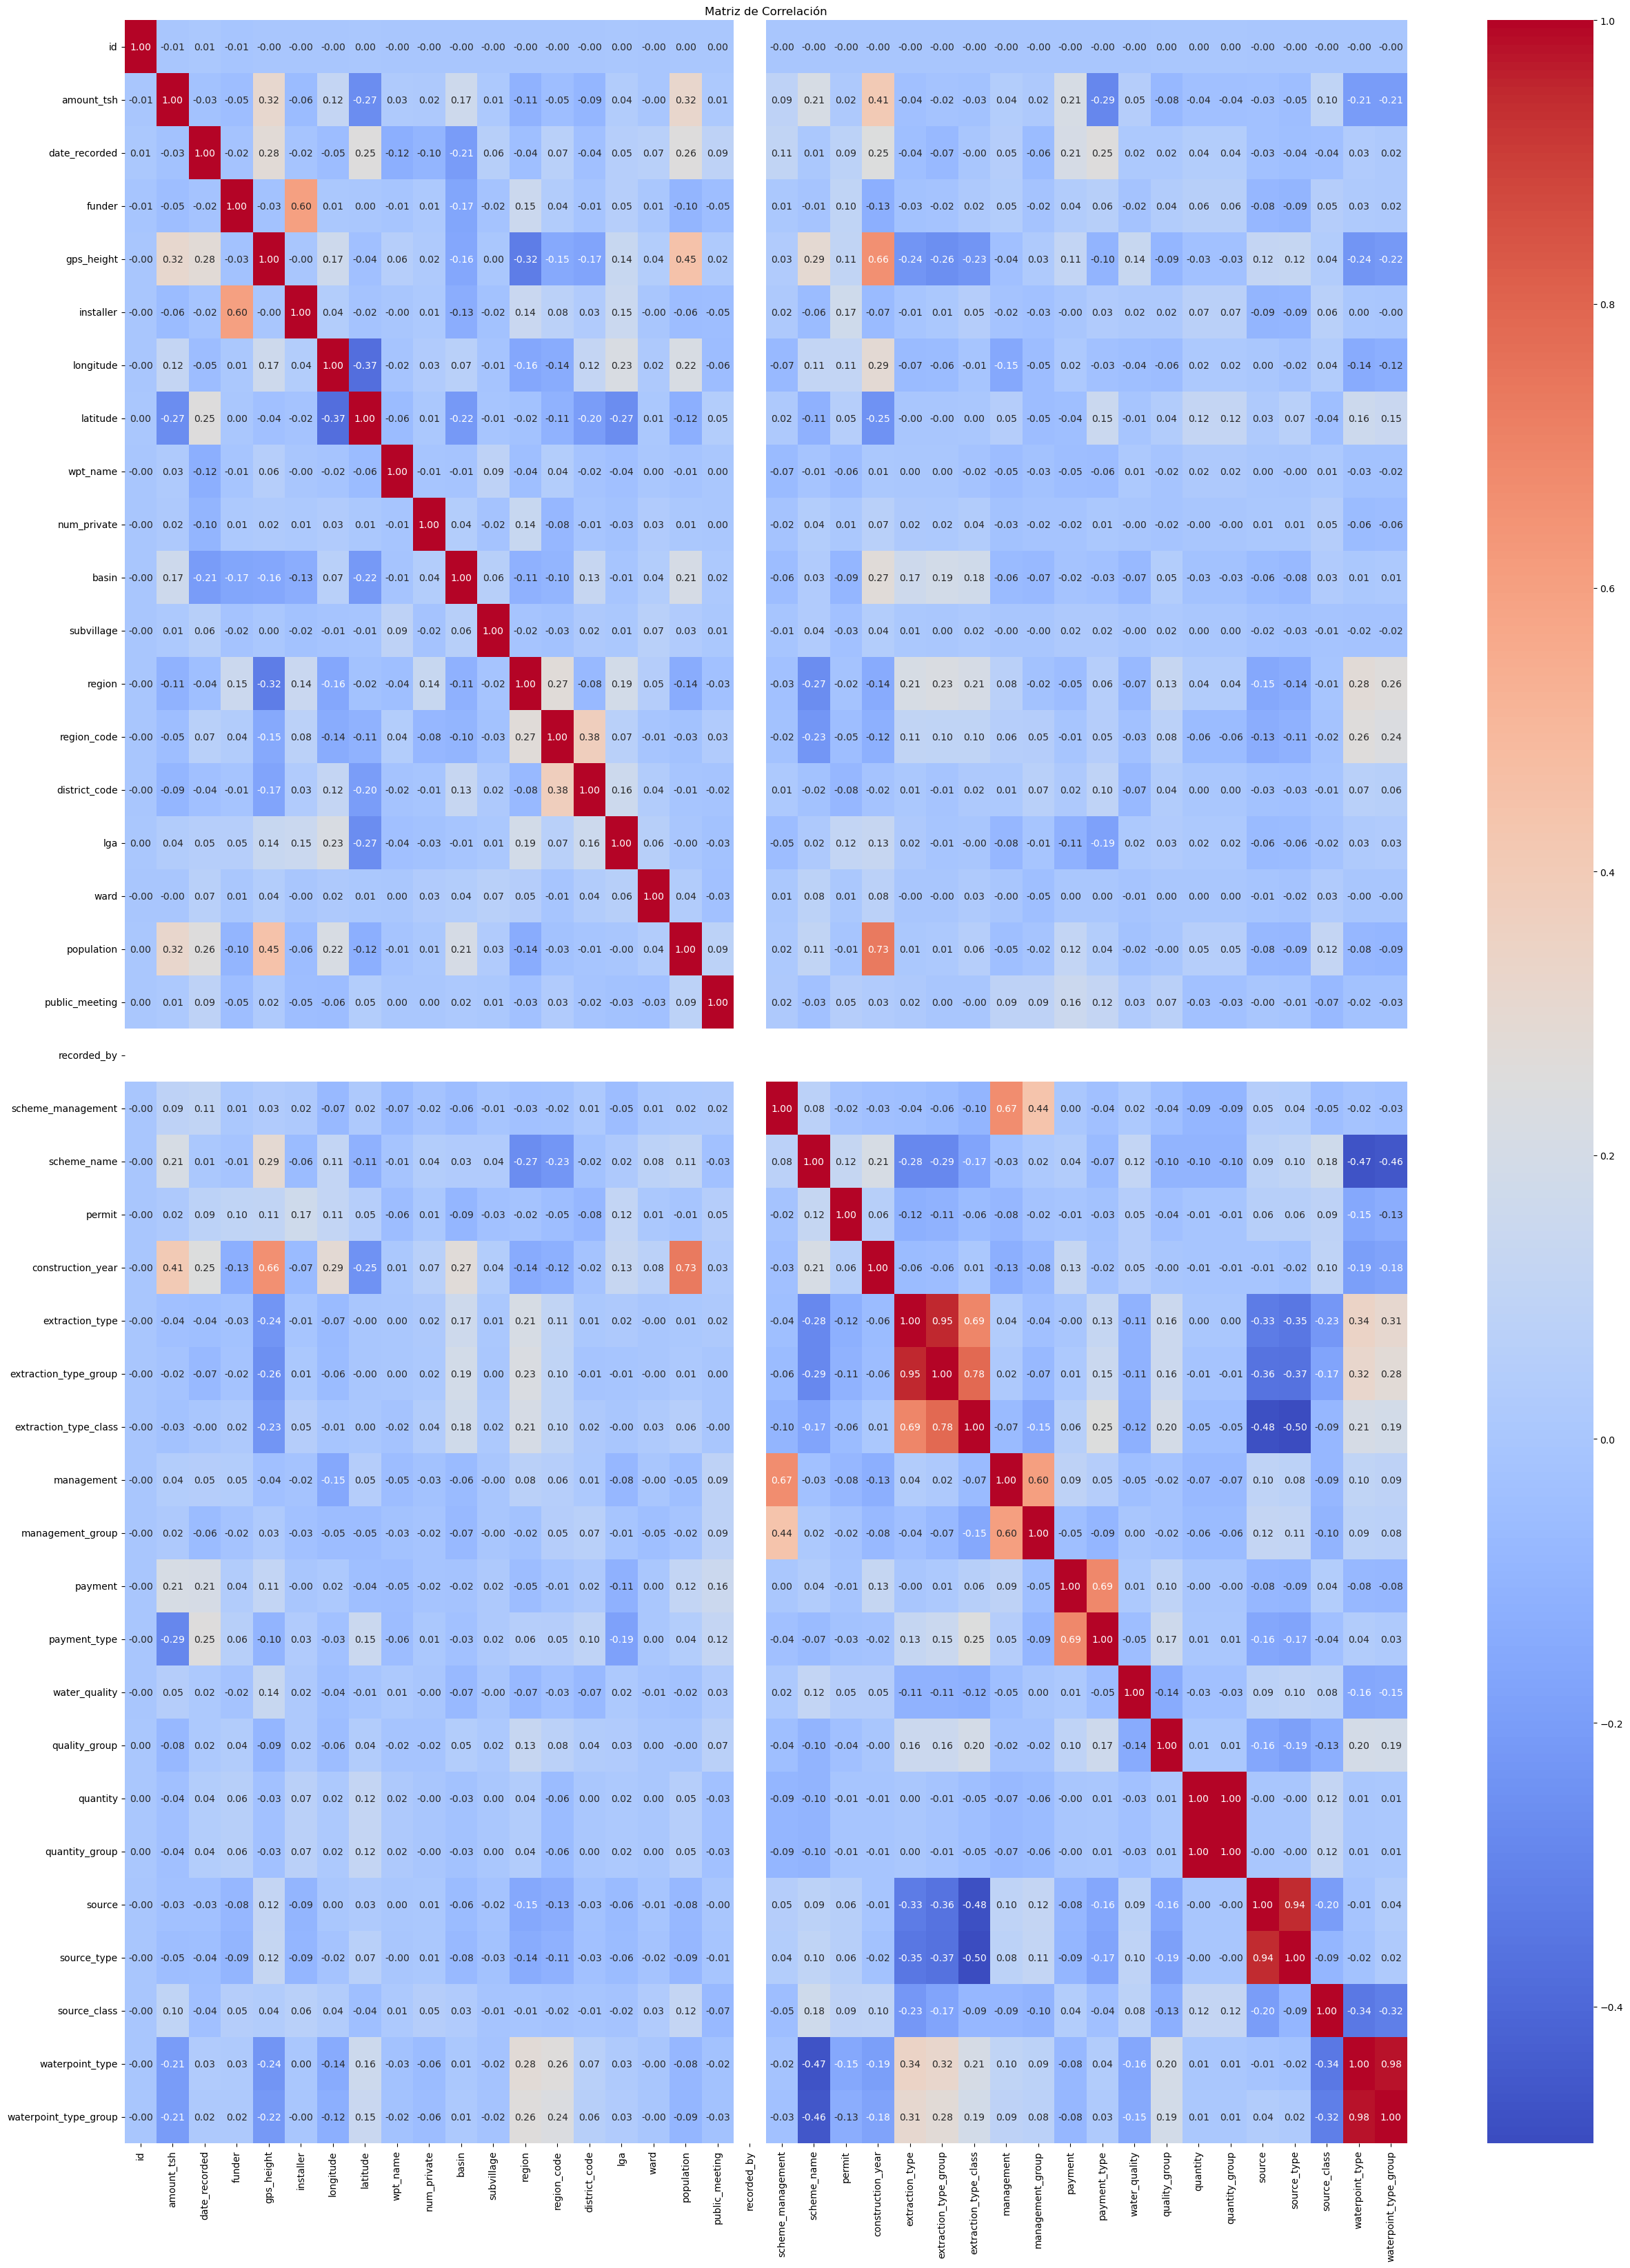

In [30]:
# Seleccionar solo columnas numéricas
matriz = data_total.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
matriz_correlación = matriz.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(30, 40))
sns.heatmap(matriz_correlación, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Primero, reemplaza 'desc' por un valor que pueda ser manejado, por ejemplo, un número
y_train_cleaned = y_train.replace('UNKNOWN')

# Codifica las categorías
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_cleaned)

C:\Users\adria\AppData\Local\Temp\ipykernel_10924\1883703234.py:5: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  y_train_cleaned = y_train.replace('UNKNOWN')


In [32]:
from sklearn.model_selection import train_test_split

# Supongamos que 'data_total' es tu DataFrame final
X = data_total
y = y_train

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Inicializar y entrenar el modelo
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Hacer predicciones
y_pred_log_reg = log_reg.predict(X_test)

# Evaluar el modelo
print("Regresión Logística")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Regresión Logística
Accuracy: 0.637979797979798
              precision    recall  f1-score   support

           0       0.52      0.02      0.04      4552
           1       0.64      0.99      0.78      9465
           2       0.00      0.00      0.00       833

    accuracy                           0.64     14850
   macro avg       0.39      0.34      0.27     14850
weighted avg       0.57      0.64      0.51     14850



C:\Users\adria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

## Modelo Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [37]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
random_forest.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [38]:
# Hacer predicciones
y_pred_random_forest = random_forest.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred_random_forest)
report = classification_report(y_test, y_pred_random_forest)

print(f'Accuracy: {accuracy:.4f}')
print(report)


Accuracy: 0.7740
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      4552
           1       0.81      0.86      0.83      9465
           2       0.53      0.29      0.37       833

    accuracy                           0.77     14850
   macro avg       0.69      0.61      0.64     14850
weighted avg       0.77      0.77      0.77     14850

